# 2D Mixture Density Network

An extension of Bishops' classic MDN prediction task to 2-dimensions.

The idea in this task is to predict a the value of a two inverse sine functions simultaneously. This function has multiple real-valued solutions at each point, so the ANN model needs to have the capacity to handle this in it's loss function. An MDN is a good way to handle the predictions of these multiple output values.

This implementation owes much to the following:

- [David Ha - Mixture Density Networks with TensorFlow](http://blog.otoro.net/2015/11/24/mixture-density-networks-with-tensorflow/)
- [Mixture Density Networks in Edward](http://edwardlib.org/tutorials/mixture-density-network)

In [8]:
import keras
from keras import backend as K
from keras.layers import Dense, Input, merge
from keras.engine.topology import Layer
import numpy as np
from tensorflow.contrib.distributions import Categorical, Mixture, MultivariateNormalDiag
import tensorflow as tf

def elu_plus_one_plus_epsilon(x):
    """ELU activation with a very small addition to help prevent NaN in loss."""
    return (K.elu(x) + 1 + 1e-8)
    

class MDN(Layer):
    """A Mixture Density Network Layer for Keras.
    This layer has a few tricks to avoid NaNs in the loss function when training:
        - Activation for variances is ELU + 1 + 1e-8 (to avoid very small values)
        - Mixture weights (pi) are trained in as logits, not in the softmax space.
        
    A loss function needs to be constructed with the same output dimension and number of mixtures.
    A sampling function is also provided to sample from distribution parametrised by the MDN outputs.
    """
    
    def __init__(self, output_dim, num_mix, **kwargs):
        self.output_dim = output_dim
        self.num_mix = num_mix
        with tf.name_scope('MDN'):
            self.mdn_mus     = Dense(self.num_mix * self.output_dim, name='mdn_mus') # mix*output vals, no activation
            self.mdn_sigmas  = Dense(self.num_mix * self.output_dim, activation=elu_plus_one_plus_epsilon, name='mdn_sigmas') # mix*output vals exp activation
            self.mdn_pi      = Dense(self.num_mix, name='mdn_pi') # mix vals, logits
        super(MDN, self).__init__(**kwargs)

    def build(self, input_shape):
        self.mdn_mus.build(input_shape)
        self.mdn_sigmas.build(input_shape)
        self.mdn_pi.build(input_shape)
        self.trainable_weights = self.mdn_mus.trainable_weights + self.mdn_sigmas.trainable_weights + self.mdn_pi.trainable_weights
        self.non_trainable_weights = self.mdn_mus.non_trainable_weights + self.mdn_sigmas.non_trainable_weights + self.mdn_pi.non_trainable_weights
        super(MDN, self).build(input_shape)
        
    def call(self, x, mask=None):
        with tf.name_scope('MDN'):
            mdn_out = keras.layers.concatenate([self.mdn_mus(x), 
                                                self.mdn_sigmas(x), 
                                                self.mdn_pi(x)], 
                                               name='mdn_outputs')
        return mdn_out
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)



def get_mixture_loss_func(output_dim, num_mixes):
    """Construct a loss functions for the MDN layer parametrised by number of mixtures."""
    
    # Construct a loss function with the right number of mixtures and outputs
    def loss_func(y_true, y_pred):
        out_mu, out_sigma, out_pi = tf.split(y_pred, num_or_size_splits=[num_mixes * output_dim, 
                                                                         num_mixes * output_dim, 
                                                                         num_mixes], 
                                             axis=1, name='mdn_coef_split')
        cat = Categorical(logits=out_pi)
        component_splits = [output_dim] * num_mixes
        mus = tf.split(out_mu, num_or_size_splits=component_splits, axis=1)
        sigs = tf.split(out_sigma, num_or_size_splits=component_splits, axis=1)
        coll = [MultivariateNormalDiag(loc=loc, scale_diag=scale) for loc, scale
            in zip(mus, sigs)]
        mixture = Mixture(cat=cat, components=coll)
        loss = mixture.log_prob(y_true)
        loss = tf.negative(loss)
        loss = tf.reduce_mean(loss)
        return loss
    
    # Actually return the loss_func
    with tf.name_scope('MDN'):
        return loss_func
    
def get_mixture_sampling_fun(output_dim, num_mixes):
    """Construct a sampling function for the MDN layer parametrised by mixtures and output dimension."""
        
    # Construct a loss function with the right number of mixtures and outputs
    def sampling_func(y_pred):
        out_mu, out_sigma, out_pi = tf.split(y_pred, num_or_size_splits=[num_mixes * output_dim, 
                                                                         num_mixes * output_dim, 
                                                                         num_mixes], 
                                             axis=1, name='mdn_coef_split')
        cat = Categorical(logits=out_pi)
        component_splits = [output_dim] * num_mixes
        mus = tf.split(out_mu, num_or_size_splits=component_splits, axis=1)
        sigs = tf.split(out_sigma, num_or_size_splits=component_splits, axis=1)
        coll = [MultivariateNormalDiag(loc=loc, scale_diag=scale) for loc, scale
            in zip(mus, sigs)]
        mixture = Mixture(cat=cat, components=coll)
        samp = mixture.sample()
        # Todo: temperature adjustment for sampling function.
        return samp
    
    # Actually return the loss_func
    with tf.name_scope('MDNLayer'):
        return sampling_func
    
def get_mixture_mse_accuracy(output_dim, num_mixes):
    """Construct an MSE accuracy function for the MDN layer 
    that takes one sample and compares to the true value."""
    
    # Construct a loss function with the right number of mixtures and outputs
    def mse_func(y_true, y_pred):
        out_mu, out_sigma, out_pi = tf.split(y_pred, num_or_size_splits=[num_mixes * output_dim, 
                                                                         num_mixes * output_dim, 
                                                                         num_mixes], 
                                             axis=1, name='mdn_coef_split')
        cat = Categorical(logits=out_pi)
        component_splits = [output_dim] * num_mixes
        mus = tf.split(out_mu, num_or_size_splits=component_splits, axis=1)
        sigs = tf.split(out_sigma, num_or_size_splits=component_splits, axis=1)
        coll = [MultivariateNormalDiag(loc=loc, scale_diag=scale) for loc, scale
            in zip(mus, sigs)]
        mixture = Mixture(cat=cat, components=coll)
        samp = mixture.sample()
        mse = tf.reduce_mean(tf.square(samp - y_true), axis=-1)
        # Todo: temperature adjustment for sampling functon.
        return mse
    
    # Actually return the loss_func
    with tf.name_scope('MDNLayer'):
        return mse_func

## Generate Synthetic Data

Data generation

<IPython.core.display.Javascript object>


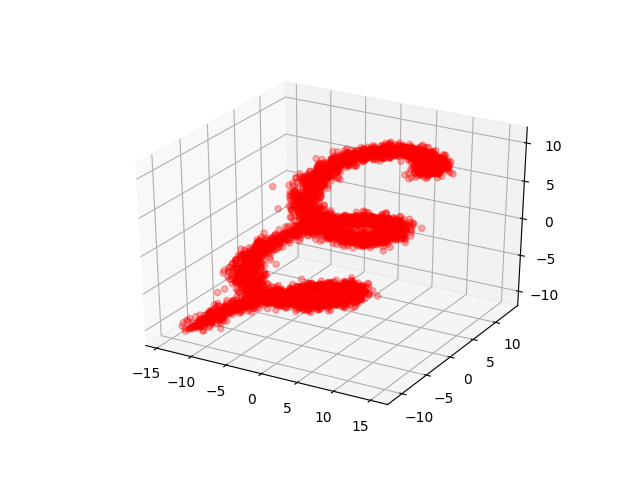

In [27]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
%matplotlib notebook

## Generating some data:
NSAMPLE = 5000

z_data = np.float32(np.random.uniform(-10.5, 10.5, NSAMPLE))
r_data = np.random.normal(size=NSAMPLE)
s_data = np.random.normal(size=NSAMPLE)
x_data = np.sin(0.75 * z_data) * 7.0 + z_data * 0.5 + r_data * 1.0
y_data = np.cos(0.80 * z_data) * 6.5 + z_data * 0.5 + s_data * 1.0

x_input = z_data.reshape((NSAMPLE, 1))
y_input = np.array([x_data,y_data])
y_input = y_input.T #reshape to (NSAMPLE,2)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_data, y_data, z_data, alpha=0.3, c='r') #c=perf_down_sampled.moving
plt.show()

## Build the MDN Model

Now we will construct the MDN model in Keras. This uses the `Sequential` model interface in Keras.

The `MDN` layer comes after one or more `Dense` layers. You need to define the output dimension and number of mixtures for the MDN like so: `MDN(output_dimension, number_mixtures)`.

For this problem, we only need an output dimension of 1 as we are predicting one value (y). Adding more mixtures adds a more parameters (model is more complex, takes longer to train), but might help make the solutions better. You can see from the training data that there are at maximum 5 different layers to predict in the curve, so setting `N_MIXES = 5` is a good place to start.

For MDNs, we have to use a special loss function that can handle the mixture parameters: the function has to take into account the number of output dimensions and mixtures.

In [9]:
N_HIDDEN = 15
N_MIXES = 10
OUTPUT_DIMS = 2

model = keras.Sequential()
model.add(keras.layers.Dense(N_HIDDEN, batch_input_shape=(None, 1), activation='relu'))
model.add(keras.layers.Dense(N_HIDDEN, activation='relu'))
model.add(MDN(OUTPUT_DIMS, N_MIXES))
model.compile(loss=get_mixture_loss_func(OUTPUT_DIMS,N_MIXES), optimizer=keras.optimizers.Adam()) #, metrics=[get_mixture_mse_accuracy(1,3)])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 15)                30        
_________________________________________________________________
dense_6 (Dense)              (None, 15)                240       
_________________________________________________________________
mdn_3 (MDN)                  (None, 2)                 800       
Total params: 1,070
Trainable params: 1,070
Non-trainable params: 0
_________________________________________________________________


### Training the model

Now we train the model using Keras' normal `fit` command.

In [10]:
history = model.fit(x=x_input, y=y_input, batch_size=128, epochs=500, validation_split=0.15, callbacks=[keras.callbacks.TerminateOnNaN()])

Train on 4250 samples, validate on 750 samples
Epoch 1/500
4250/4250 [==============================] - 2s 402us/step - loss: 14.0582 - val_loss: 12.0144
Epoch 2/500
4250/4250 [==============================] - 0s 30us/step - loss: 10.6736 - val_loss: 9.5525
Epoch 3/500
4250/4250 [==============================] - 0s 30us/step - loss: 8.7016 - val_loss: 8.0313
Epoch 4/500
4250/4250 [==============================] - 0s 30us/step - loss: 7.4954 - val_loss: 7.1171
Epoch 5/500
4250/4250 [==============================] - 0s 31us/step - loss: 6.8195 - val_loss: 6.6035
Epoch 6/500
4250/4250 [==============================] - 0s 30us/step - loss: 6.4911 - val_loss: 6.3975
Epoch 7/500
4250/4250 [==============================] - 0s 29us/step - loss: 6.3334 - val_loss: 6.2763
Epoch 8/500
4250/4250 [==============================] - 0s 30us/step - loss: 6.2254 - val_loss: 6.1868
Epoch 9/500
4250/4250 [==============================] - 0s 31us/step - loss: 6.1330 - val_loss: 6.1053
Epoch 10/500


4250/4250 [==============================] - 0s 30us/step - loss: 3.4691 - val_loss: 3.5452
Epoch 79/500
4250/4250 [==============================] - 0s 30us/step - loss: 3.4677 - val_loss: 3.5257
Epoch 80/500
4250/4250 [==============================] - 0s 31us/step - loss: 3.4511 - val_loss: 3.5095
Epoch 81/500
4250/4250 [==============================] - 0s 30us/step - loss: 3.4423 - val_loss: 3.4978
Epoch 82/500
4250/4250 [==============================] - 0s 30us/step - loss: 3.4378 - val_loss: 3.4940
Epoch 83/500
4250/4250 [==============================] - 0s 30us/step - loss: 3.4209 - val_loss: 3.4948
Epoch 84/500
4250/4250 [==============================] - 0s 30us/step - loss: 3.4196 - val_loss: 3.4947
Epoch 85/500
4250/4250 [==============================] - 0s 30us/step - loss: 3.4033 - val_loss: 3.4716
Epoch 86/500
4250/4250 [==============================] - 0s 31us/step - loss: 3.3944 - val_loss: 3.4659
Epoch 87/500
4250/4250 [==============================] - 0s 30us/st

4250/4250 [==============================] - 0s 30us/step - loss: 3.0719 - val_loss: 3.1599
Epoch 156/500
4250/4250 [==============================] - 0s 30us/step - loss: 3.0793 - val_loss: 3.1253
Epoch 157/500
4250/4250 [==============================] - 0s 30us/step - loss: 3.0659 - val_loss: 3.1197
Epoch 158/500
4250/4250 [==============================] - 0s 30us/step - loss: 3.0646 - val_loss: 3.1501
Epoch 159/500
4250/4250 [==============================] - 0s 30us/step - loss: 3.0625 - val_loss: 3.1241
Epoch 160/500
4250/4250 [==============================] - 0s 30us/step - loss: 3.0709 - val_loss: 3.1043
Epoch 161/500
4250/4250 [==============================] - 0s 30us/step - loss: 3.0626 - val_loss: 3.1305
Epoch 162/500
4250/4250 [==============================] - 0s 32us/step - loss: 3.0527 - val_loss: 3.1098
Epoch 163/500
4250/4250 [==============================] - 0s 30us/step - loss: 3.0526 - val_loss: 3.0989
Epoch 164/500
4250/4250 [==============================] - 0

4250/4250 [==============================] - 0s 30us/step - loss: 2.9419 - val_loss: 3.0059
Epoch 233/500
4250/4250 [==============================] - 0s 30us/step - loss: 2.9454 - val_loss: 2.9825
Epoch 234/500
4250/4250 [==============================] - 0s 30us/step - loss: 2.9416 - val_loss: 2.9993
Epoch 235/500
4250/4250 [==============================] - 0s 30us/step - loss: 2.9377 - val_loss: 2.9983
Epoch 236/500
4250/4250 [==============================] - 0s 30us/step - loss: 2.9346 - val_loss: 3.0136
Epoch 237/500
4250/4250 [==============================] - 0s 30us/step - loss: 2.9360 - val_loss: 3.0070
Epoch 238/500
4250/4250 [==============================] - 0s 30us/step - loss: 2.9343 - val_loss: 2.9845
Epoch 239/500
4250/4250 [==============================] - 0s 30us/step - loss: 2.9346 - val_loss: 2.9922
Epoch 240/500
4250/4250 [==============================] - 0s 30us/step - loss: 2.9321 - val_loss: 2.9837
Epoch 241/500
4250/4250 [==============================] - 0

4250/4250 [==============================] - 0s 31us/step - loss: 2.9168 - val_loss: 2.9798
Epoch 310/500
4250/4250 [==============================] - 0s 29us/step - loss: 2.9115 - val_loss: 2.9876
Epoch 311/500
4250/4250 [==============================] - 0s 30us/step - loss: 2.9149 - val_loss: 2.9728
Epoch 312/500
4250/4250 [==============================] - 0s 30us/step - loss: 2.9095 - val_loss: 2.9749
Epoch 313/500
4250/4250 [==============================] - 0s 30us/step - loss: 2.9111 - val_loss: 2.9783
Epoch 314/500
4250/4250 [==============================] - 0s 30us/step - loss: 2.9122 - val_loss: 2.9757
Epoch 315/500
4250/4250 [==============================] - 0s 30us/step - loss: 2.9103 - val_loss: 2.9840
Epoch 316/500
4250/4250 [==============================] - 0s 33us/step - loss: 2.9065 - val_loss: 2.9726
Epoch 317/500
4250/4250 [==============================] - 0s 32us/step - loss: 2.9063 - val_loss: 2.9865
Epoch 318/500
4250/4250 [==============================] - 0

4250/4250 [==============================] - 0s 30us/step - loss: 2.8964 - val_loss: 2.9744
Epoch 387/500
4250/4250 [==============================] - 0s 30us/step - loss: 2.8977 - val_loss: 2.9815
Epoch 388/500
4250/4250 [==============================] - 0s 31us/step - loss: 2.8984 - val_loss: 2.9534
Epoch 389/500
4250/4250 [==============================] - 0s 30us/step - loss: 2.8984 - val_loss: 2.9500
Epoch 390/500
4250/4250 [==============================] - 0s 30us/step - loss: 2.9032 - val_loss: 2.9548
Epoch 391/500
4250/4250 [==============================] - 0s 30us/step - loss: 2.8944 - val_loss: 2.9581
Epoch 392/500
4250/4250 [==============================] - 0s 30us/step - loss: 2.8913 - val_loss: 2.9635
Epoch 393/500
4250/4250 [==============================] - 0s 31us/step - loss: 2.8889 - val_loss: 2.9699
Epoch 394/500
4250/4250 [==============================] - 0s 31us/step - loss: 2.9010 - val_loss: 2.9751
Epoch 395/500
4250/4250 [==============================] - 0

4250/4250 [==============================] - 0s 30us/step - loss: 2.8842 - val_loss: 2.9669
Epoch 464/500
4250/4250 [==============================] - 0s 30us/step - loss: 2.8998 - val_loss: 2.9947
Epoch 465/500
4250/4250 [==============================] - 0s 29us/step - loss: 2.8952 - val_loss: 2.9678
Epoch 466/500
4250/4250 [==============================] - 0s 30us/step - loss: 2.8888 - val_loss: 2.9620
Epoch 467/500
4250/4250 [==============================] - 0s 32us/step - loss: 2.8893 - val_loss: 2.9515
Epoch 468/500
4250/4250 [==============================] - 0s 31us/step - loss: 2.8913 - val_loss: 2.9462
Epoch 469/500
4250/4250 [==============================] - 0s 29us/step - loss: 2.8881 - val_loss: 2.9626
Epoch 470/500
4250/4250 [==============================] - 0s 31us/step - loss: 2.8873 - val_loss: 2.9674
Epoch 471/500
4250/4250 [==============================] - 0s 32us/step - loss: 2.8809 - val_loss: 2.9748
Epoch 472/500
4250/4250 [==============================] - 0

### Training and Validation Loss

It's interesting to see how the model trained. We can see that after a certain point improvement in training is rather slow.

For this problem a loss value around 3.0 produces quite good results.

<IPython.core.display.Javascript object>


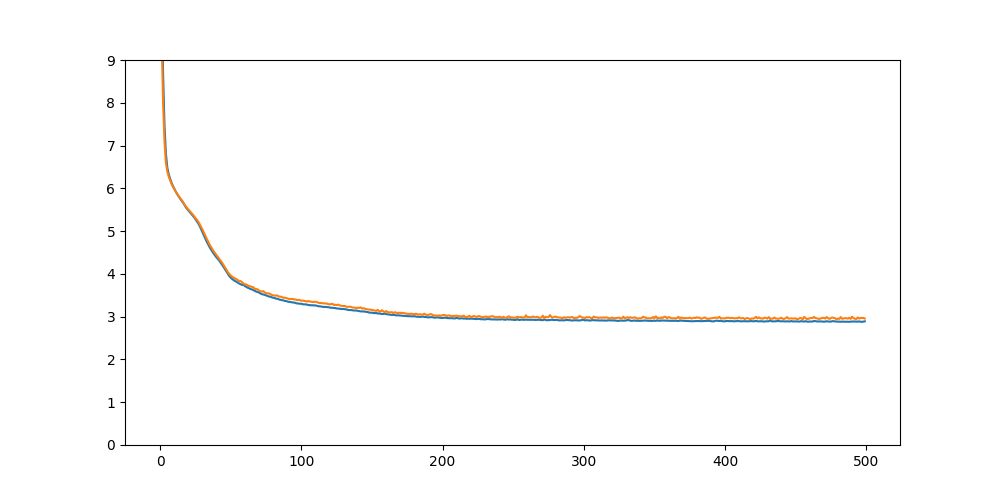

In [28]:
plt.figure(figsize=(10, 5))
plt.ylim([0,9])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

## Sampling Functions

The MDN model outputs parameters of a mixture model---a list of means (mu), variances (sigma), and weights (pi).

Below we have some functiosn to split up these parameters and sample from the normal distributions that they form.

In [17]:
# Sample from Categorical distribution
def sample_mixture(mus, sigs, pis):
    """Sample from a mixture of 1D normal distributions parameterised by mus, sigma, and pi."""
    m = np.random.choice(range(len(pis)), p=pis)
    return(np.random.normal(mus[m],sigs[m],1))

def split_mixture_params(params, mixtures, dim):
    """Splits up an array of mixture parameters into mus, sigmas, and pis 
    depending on the number of mixtures and output dimension."""
    mus = params[:mixtures*dim]
    sigs = params[mixtures*dim:2*mixtures*dim]
    pis = params[2*mixtures*dim:]
    return mus,sigs,pis

def adjust_temp(pi_pdf, temp):
    """ Adjusts temperature of a PDF describing a categorical model """
    pi_pdf = np.log(pi_pdf) / temp
    pi_pdf -= pi_pdf.max()
    pi_pdf = np.exp(pi_pdf)
    pi_pdf /= pi_pdf.sum()
    return pi_pdf

def get_pi_idx(x, pdf, temp=1.0, greedy=False):
    """Samples from a categorical model PDF, optionally greedily."""
    if greedy:
        return np.argmax(pdf)
    pdf = adjust_temp(np.copy(pdf), temp)
    accumulate = 0
    for i in range(0, pdf.size):
        accumulate += pdf[i]
        if accumulate >= x:
            return i
    tf.logging.info('Error sampling mixture model.')
    return -1

def sample_from_categorical(dist, temp):
    """Sample from a categorical model with temperature adjustment."""
    r = np.random.rand(1)
    return get_pi_idx(r,dist,temp)

def softmax(w, t=1.0):
    """Softmax function for a list or numpy array of logits."""
    e = np.exp(np.array(w) / t)
    dist = e / np.sum(e)
    return dist

def sample_from_output_1D(params, mixtures, dim, temp=1.0):
    """Sample from a 1D MDN output with temperature adjustment."""
    mus = params[:mixtures*dim]
    sigs = params[mixtures*dim:2*mixtures*dim]
    pis = params[-mixtures:]
    m = sample_from_categorical(pis, temp=temp)
    return(np.random.normal(mus[m],sigs[m],1))

def sample_from_output(params, mixtures, dim, temp=1.0):
    """Sample from an MDN output with temperature adjustment."""
    mus = params[:mixtures*dim]
    sigs = params[mixtures*dim:2*mixtures*dim]
    pis = softmax(params[-mixtures:], t=temp)
    m = sample_from_categorical(pis, temp=temp)
    mus_vector = mus[m*dim:(m+1)*dim]
    sig_vector = sigs[m*dim:(m+1)*dim]
    cov_matrix = np.identity(dim) * sig_vector
    sample = np.random.multivariate_normal(mus_vector, cov_matrix, 1)
    return sample

## Try out the MDN Model

Now we try out the model by making predictions at 3000 evenly spaced points on the x-axis. 

Mixture models output lists of parameters, so we're going to sample from these parameters for each point on the x-axis, and also try plotting the parameters themselves so we can have some insight into what the model is learning!

In [22]:
## Sample on some test data:
x_test = np.float32(np.arange(-15,15,0.1))
NTEST = x_test.size
print("Testing:", NTEST, "samples.")
x_test = x_test.reshape(NTEST,1) # needs to be a matrix, not a vector

# Make predictions from the model
y_test = model.predict(x_test)
# y_test contains parameters for distributions, not actual points on the graph.
# To find points on the graph, we need to sample from each distribution.

# Split up the mixture parameters (for future fun)
mus = np.apply_along_axis((lambda a: a[:N_MIXES*OUTPUT_DIMS]),1, y_test)
sigs = np.apply_along_axis((lambda a: a[N_MIXES*OUTPUT_DIMS:2*N_MIXES*OUTPUT_DIMS]),1, y_test)
pis = np.apply_along_axis((lambda a: softmax(a[-N_MIXES:])),1, y_test)

# Sample from the predicted distributions
y_samples = np.apply_along_axis(sample_from_output, 1, y_test, N_MIXES,OUTPUT_DIMS,temp=1.0)

Testing: 300 samples.


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


<IPython.core.display.Javascript object>


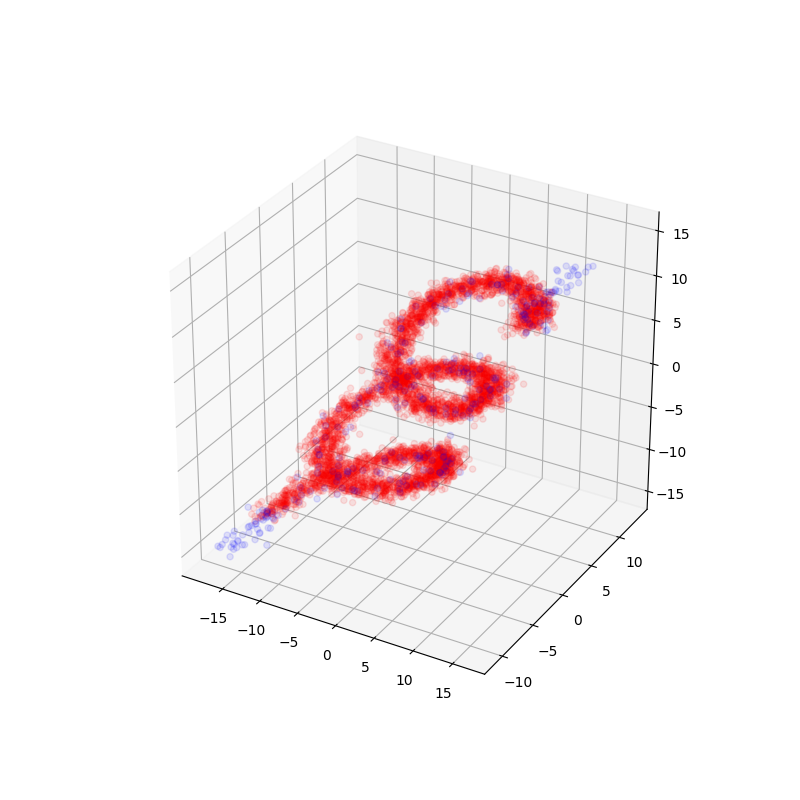

In [29]:
# Plot the predicted samples.
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_data, y_data, z_data, alpha=0.1, c='r') #c=perf_down_sampled.moving
ax.scatter(y_samples.T[0], y_samples.T[1], x_test, alpha=0.1, c='b') #c=perf_down_sampled.moving
plt.show()

<IPython.core.display.Javascript object>


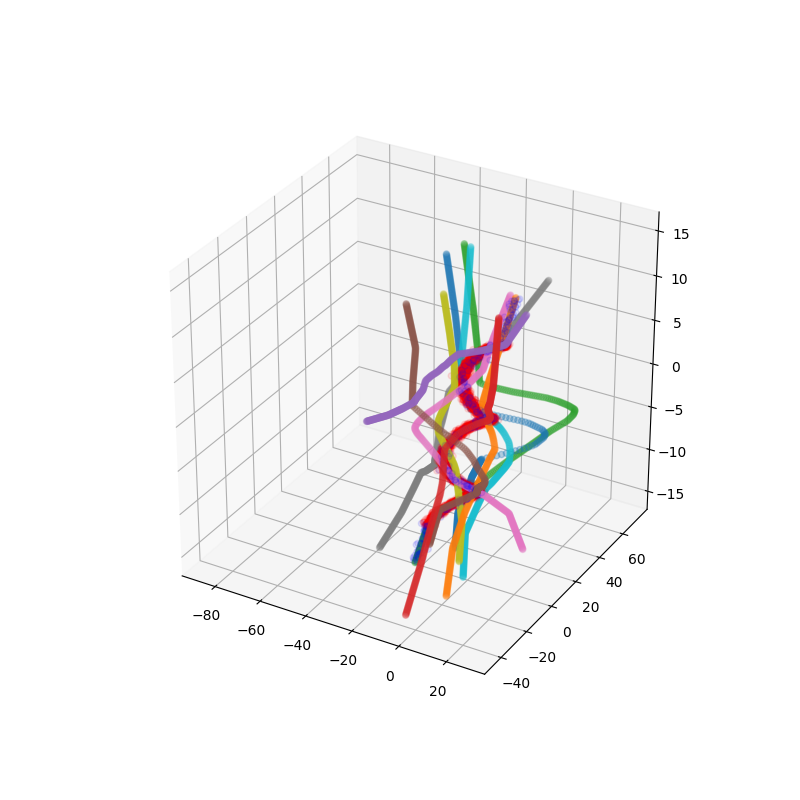

In [30]:
# Plot the means - this gives us some insight into how the model learns to produce the mixtures.
# Cool!

# Plot the predicted samples.
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_data, y_data, z_data, alpha=0.1, c='r') #c=perf_down_sampled.moving
ax.scatter(y_samples.T[0], y_samples.T[1], x_test, alpha=0.1, c='b') #c=perf_down_sampled.moving
for m in range(N_MIXES):
    one_pair = mus[m*OUTPUT_DIMS:(m+1)*OUTPUT_DIMS]
    ax.scatter(mus[:,2*m], mus[:,2*m + 1] , x_test, marker='o',alpha=0.3)
plt.show()

<IPython.core.display.Javascript object>


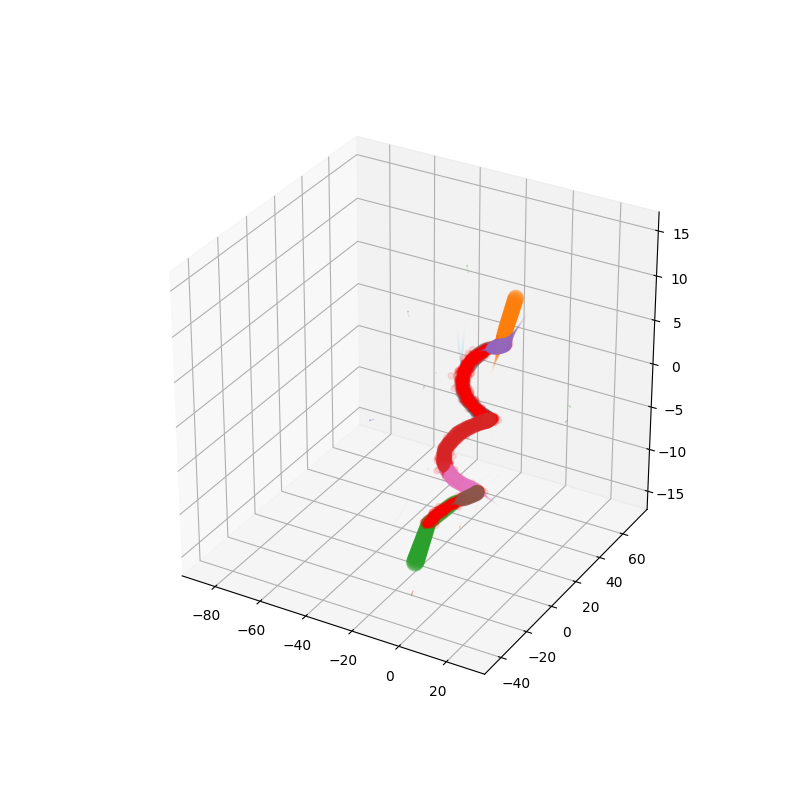

In [31]:
# Let's plot the variances and weightings of the means as well.

# Plot the predicted samples.
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_data, y_data, z_data, alpha=0.1, c='r') #c=perf_down_sampled.moving
for m in range(N_MIXES):
    one_pair = mus[m*OUTPUT_DIMS:(m+1)*OUTPUT_DIMS]
    ax.scatter(mus[:,2*m], mus[:,2*m + 1] , x_test, s=100*sigs[:,2*m]*pis[:,m], marker='o',alpha=0.3)
plt.show()